## Uniform Time Course process output comparisons

In [1]:
import sys
import os
from tempfile import mkdtemp

import numpy as np
from process_bigraph import Composite
from process_bigraph.experiments.parameter_scan import RunProcess


sys.path.insert(0, '..')

In [2]:


from biosimulator_processes.io import read_report_outputs
from biosimulator_processes.helpers import plot_utc_outputs, plot_ode_output_data

Smoldyn is not properly installed in this environment and thus its process implementation cannot be registered. Please consult smoldyn documentation.
Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra-process',
  'copasi-process',
  'tellurium-process',
  'utc-amici',
  'utc-copasi',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d']


In [3]:
from biosimulator_processes.processes.amici_process import UtcAmici
from biosimulator_processes.processes.copasi_process import UtcCopasi

In [4]:
omex_dir = '../test_suite/examples/sbml-core/Elowitz-Nature-2000-Repressilator'
omex_fp = omex_dir + '.omex'
sbml_fp = os.path.join(omex_dir, 'BIOMD0000000012_url.xml')
sedml_fp = os.path.join(omex_dir, 'simulation.sedml')
reports_path = os.path.join(omex_dir, 'reports.h5')

Configure and create an Amici UTC instance using just the archive filepath.

In [5]:
utc_amici = UtcAmici(config={'model': {'model_source': omex_dir + '.omex'}})

2024-05-31 15:20:37.051 - amici.sbml_import - INFO - Finished importing SBML                         (4.40E-02s)
2024-05-31 15:20:37.104 - amici.sbml_import - INFO - Finished processing SBML observables            (4.98E-02s)
2024-05-31 15:20:37.109 - amici.sbml_import - INFO - Finished processing SBML event observables      (8.33E-07s)
2024-05-31 15:20:37.133 - amici.de_model - INFO - Finished computing xdot                            (3.66E-03s)
2024-05-31 15:20:37.139 - amici.de_model - INFO - Finished computing x0                              (2.93E-03s)
2024-05-31 15:20:37.159 - amici.de_model - INFO - Finished computing w                               (1.64E-02s)
2024-05-31 15:20:38.008 - amici.de_export - INFO - Finished generating cpp code                      (8.45E-01s)
2024-05-31 15:20:46.746 - amici.de_export - INFO - Finished compiling cpp code                       (8.73E+00s)


In [6]:
# t range parameters set via sedml introspection within archive contents:
utc_amici.t[0], utc_amici.t[-1], utc_amici.duration, utc_amici.step_size, utc_amici.num_steps

(400.0, 1000.0, 1000, 1.0, 601)

In [7]:
# you can verify this time config against the SEDML file
!cat ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml

cat: ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml: No such file or directory


In [8]:
# run the amici utc simulation with the interface's update method:
amici_results = utc_amici.update()

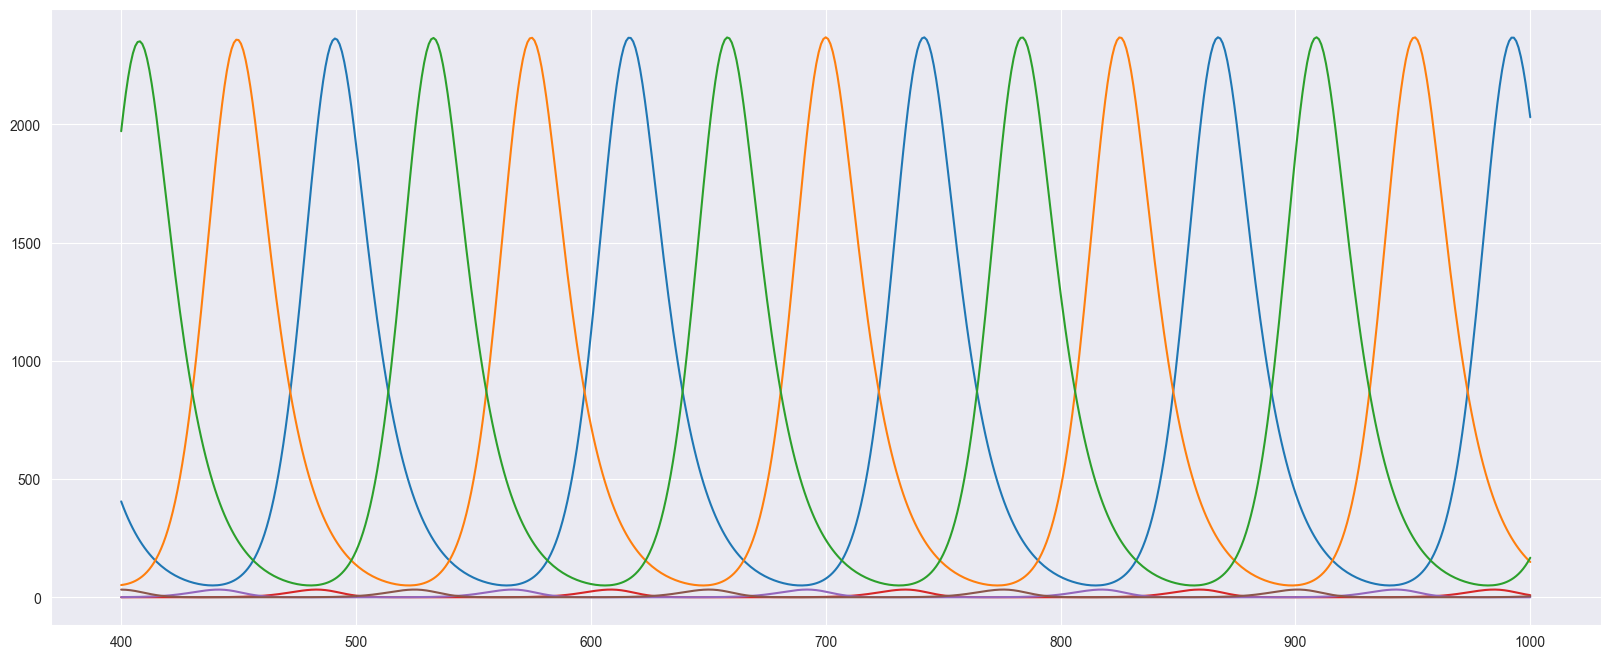

In [9]:
# use built-in plot to plot results
utc_amici.plot_results()

Create a `UtcTellurium` instance as above

In [10]:
from biosimulator_processes.processes.tellurium_process import UtcTellurium


utc_tellurium = UtcTellurium(config={'model': {'model_source': omex_dir + '.omex'}})

In [11]:
tellurium_results = utc_tellurium.update()

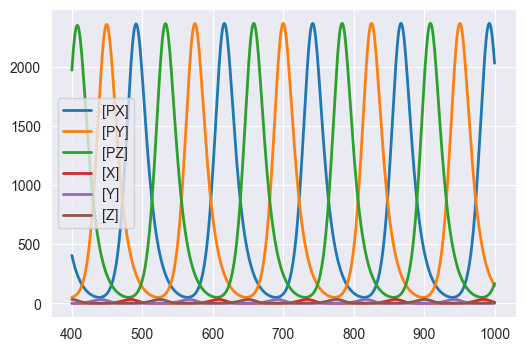

In [12]:
utc_tellurium.plot_results()

Create a `UtcCopasi` instance and run the same

In [13]:
utc_copasi = UtcCopasi(config={'model': {'model_source': omex_dir + '.omex'}})

In [14]:
copasi_results = utc_copasi.update()

<Axes: >

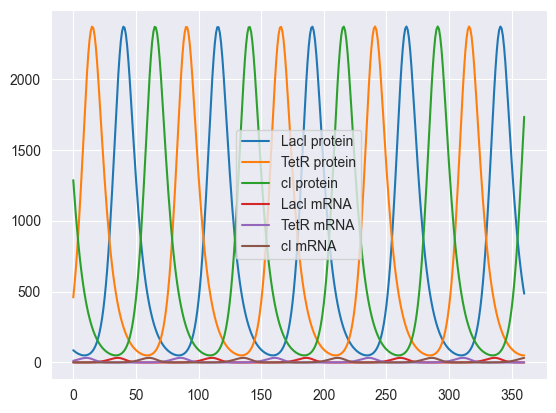

In [15]:
utc_copasi.plot_results()

Finally, optionally generate a "ground truth" which we include in the comparison. The default source for ground-truth data is via uploading an omex archive as model source. The report outputs must be included in the archive.

In [16]:
# Generate comparison matrix from ground truth
from biosimulator_processes.api.compare import write_utc_comparison_reports
from biosimulator_processes.io import standardize_report_outputs

In [17]:
report_results = standardize_report_outputs(reports_path)

In [18]:
print(f"copasi result keys: {copasi_results['floating_species'].keys()}\nTellurium result keys: {tellurium_results['floating_species'].keys()}\nAmici Result keys: {amici_results['floating_species'].keys()}\nGround truth report keys: {report_results['floating_species'].keys()}")

copasi result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Tellurium result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Amici Result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Ground truth report keys: dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])


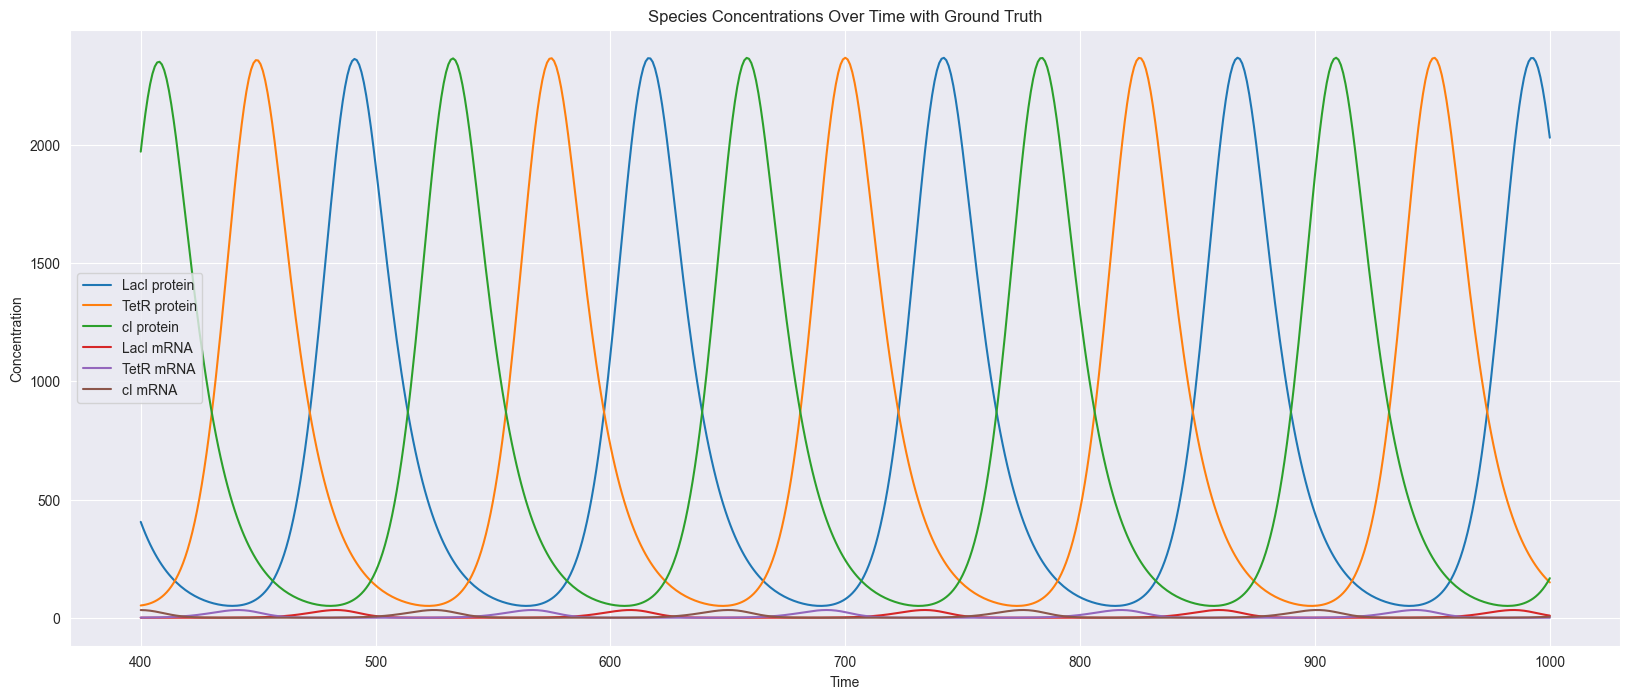

In [19]:
plot_ode_output_data(report_results, simulator_name='Ground Truth')

Generate a series of comparisons for each species and save to a given dir

In [20]:
write_utc_comparison_reports(
    save_dir='../test_outputs/repressilator-utc-comparison',
    copasi_results=copasi_results,
    tellurium_results=tellurium_results,
    amici_results=amici_results,
    ground_truth_results=report_results,
    sbml_species_mapping=utc_copasi.sbml_species_mapping,
    method='mse')

ValueError: operands could not be broadcast together with shapes (361,) (601,) 

In [ ]:
copasi_results['floating_species']['PX'].shape

In [ ]:
slice_params = infer_slice(x, outStart)

slice_params[0]

In [ ]:
len(utc_copasi.floating_species_list)

In [ ]:
np.array(list(copasi_results['floating_species'].values()))[:, slice_params[0]:slice_params[1]].shape

In [ ]:
np.array(list(report_results['floating_species'].values()))[:, slice_params[0]:slice_params[1]].shape

In [ ]:
report_results['floating_species']['cI mRNA']

In [ ]:
data = np.array([output[int(outStart/2 - 200):duration] for output in copasi_results['floating_species'].values()])
t = copasi_results['time'][int(outStart/2 - 200):duration]
data.shape, t.shape

In [ ]:
report_results_data = np.array([output for output in copasi_results['floating_species'].values()])
report_results_data.shape

In [ ]:
import seaborn as sns 

t = t.tolist()
t.append(1001.0)
t = np.array(t)
sns.lineplot(x=t, y=data[0])

In [ ]:
t.shape, data[0].shape

In [ ]:
data = np.array([output[outStart:1000] for output in copasi_results['floating_species'].values()])

In [ ]:
data.shape

In [ ]:
data.shape

In [ ]:
from biosimulators_utils.sedml.io import SedmlSimulationReader


sedml = SedmlSimulationReader().run(filename=os.path.join(omex_dir, 'simulation.sedml'))

In [21]:
import tellurium as te 
from biosimulator_processes.io import get_sedml_time_config


simulator = te.loadSBMLModel(sbml_fp)

In [22]:
time_config = get_sedml_time_config(os.path.join(omex_dir, 'simulation.sedml'))

In [23]:
output_start = int(time_config.get('outputStartTime'))
start = int(time_config.get('initialTime'))
output_end = int(time_config.get('outputEndTime'))
n_steps = int(time_config.get('numberOfPoints'))

In [24]:
initial_result = simulator.simulate(start=start, end=output_start)
result = simulator.simulate(start=output_start, end=output_end, steps=n_steps)

In [25]:
result.shape

(601, 7)

In [26]:
result[0][0]

400.0

In [27]:
report_results['time'][0]

400.0

In [28]:
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])


z = np.append(x, y)

In [29]:
start, output_start, output_end

(0, 400, 1000)

In [30]:
from basico import *


model = load_model(sbml_fp)

outputs = [k for k in utc_copasi.sbml_species_mapping.keys()]
outputs.append('Time')

tc1 = run_time_course_with_output(start_time=start, 
                                         duration=output_start, 
                                         step_number=output_start,
                                         output_selection=outputs,
                                         model=model,
                                         update_model=True)


In [31]:
tc2 = run_time_course(start_time=output_start, 
                     duration=output_end, 
                     step_number=n_steps, 
                     model=model, 
                     update_model=True,
                     output_selection=outputs)

<Axes: >

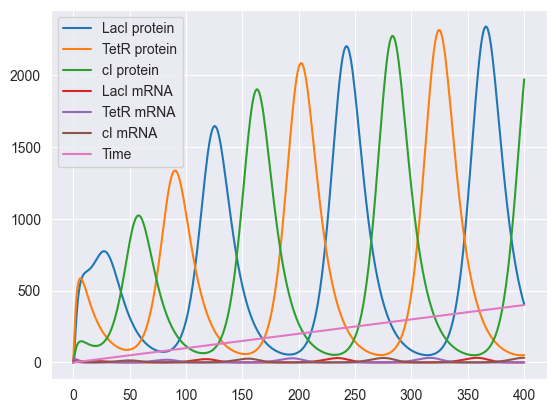

In [32]:
tc1.plot()

<Axes: xlabel='Time'>

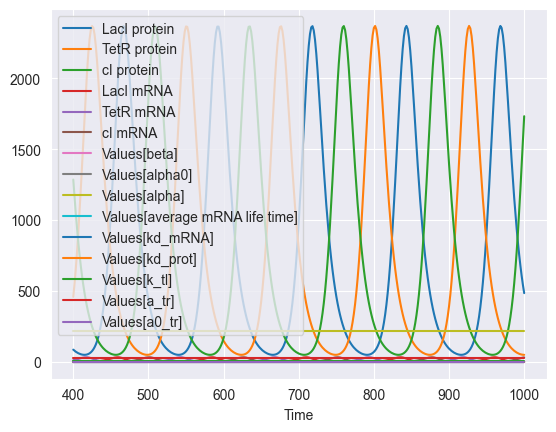

In [33]:
tc2.plot()

In [34]:
type(tc1)

pandas.core.frame.DataFrame

In [ ]:
utc_copasi.sbml_species_mapping

In [ ]:
copasi_results['floating_species']['PX'].shape

In [ ]:
output_selection=[
                                           k for k in utc_copasi.sbml_species_mapping.keys()
                                         ]

In [ ]:
output_selection

In [35]:
import pandas as pd 


tc3 = pd.concat([tc1, tc2])

In [36]:
tc3.index.tolist()[-1]

1000.0

<Axes: >

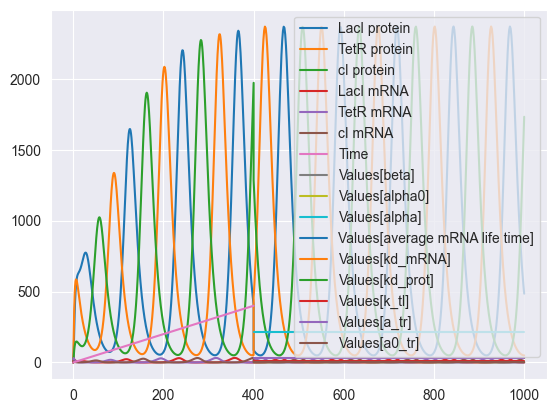

In [37]:
tc3.plot()